In [7]:
#Pour lire les fichiers
import pandas as pd
import numpy as np

#Pour créer notre diagramme
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib import style
style.use('ggplot')

import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split



In [8]:
def read_pickle_file(file):
    pickle_data = pd.read_pickle(file)
    return pickle_data



neg=read_pickle_file(r"C:\Users\naouf\OneDrive\Bureau\ML\imdb_raw_neg.pickle")
pos=read_pickle_file(r"C:\Users\naouf\OneDrive\Bureau\ML\imdb_raw_pos.pickle")



df_neg=pd.DataFrame(neg)
df_neg.columns=["review"]
df_neg["sentiment"]="Neg"

df_pos=pd.DataFrame(pos)
df_pos.columns=["review"]
df_pos["sentiment"]="Pos"


df=pd.concat([df_neg,df_pos])
df=df.sample(frac=1)

Text(0.5, 1.0, 'Sentiment distribution')

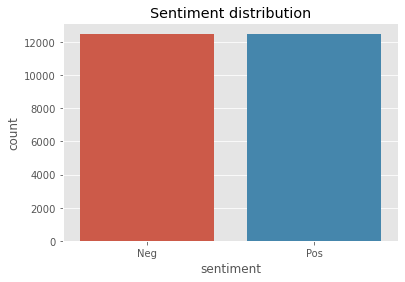

In [9]:
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment distribution")

#On constate que les avis sont bien répartis de façons équivalente

In [10]:
for i in range(5):
    print("Review: ", [i])
    print(df['review'].iloc[i], "\n")
    print("Sentiment: ", df['sentiment'].iloc[i], "\n\n")
  

Review:  [0]
I work at the video store that rents this video in Lexington and I must say...it should have never been made. I even know some of the people who worked on it who regret doing so. Bad effects, horrid acting, bad script especially. I swear the dialog wouldn't have passed for the original PSX Resident Evil; it's that bad. If you want to know how not to make a movie, watch this film to learn a thing or two. If not, don't waste your time. And even the director know it sucks because he keeps coming in to try to get us to upsale the movie. No sir. I've watched two-thirds of the horror section and this rates even lower than Plan 9 from Outer Space. Even Ed Eood would have said, "Nope. That's too stupid even for me." 

Sentiment:  Neg 


Review:  [1]
I really enjoy this movie. The first time it was on Turner Classic Movies. All the actors did very well but Brynner steals the show again like always ( he is so sexy!).This is one of the movie that you do see Brynner's emotions. Actual

In [11]:
def no_of_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

df['word count'] = df['review'].apply(no_of_words)
df.head()

#Cette fonction nous permettra de calculer le nombre de mots dans chaque commentaires, on l'utilisera pour comparer
# le nombre de mots dans chaque commentaires après avoir retirer les éventuels doublon qui risquent de fausser notre modèle

,review,sentiment,word count
9733,I work at the video store that rents this vide...,Neg,139
6454,I really enjoy this movie. The first time it w...,Pos,151
7725,"In retrospect, the 1970s was a golden era for ...",Pos,214
6679,I love the other reviews of this movie. They m...,Pos,576
12169,This movie is just about as good as the first ...,Pos,141


In [12]:
df.sentiment.replace("Pos", 1, inplace=True)
df.sentiment.replace("Neg", 2, inplace=True)

df.head()

,review,sentiment,word count
9733,I work at the video store that rents this vide...,2,139
6454,I really enjoy this movie. The first time it w...,1,151
7725,"In retrospect, the 1970s was a golden era for ...",1,214
6679,I love the other reviews of this movie. They m...,1,576
12169,This movie is just about as good as the first ...,1,141


In [13]:
def data_processing(text):
    text= text.lower()
    text = re.sub('', '', text)
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

df.review = df['review'].apply(data_processing)

In [14]:
duplicated_count = df.duplicated().sum()

In [15]:
df = df.drop_duplicates('review')

In [16]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

df.review = df['review'].apply(lambda x: stemming(x))
df['word count'] = df['review'].apply(no_of_words)
df.head()

#En comparant le nombre de mots initials avec celui que nous avons à présent on voit bien que les doublons on bien étais retirés

,review,sentiment,word count
9733,work video store rents video lexington must sa...,2,76
6454,really enjoy movie first time turner classic m...,1,72
7725,retrospect 1970s golden era american cinema de...,1,115
6679,love reviews movie mirror attitude 70s sort gu...,1,318
12169,movie good first jackass slightly disgusting s...,1,67


In [17]:
pos_reviews =  df[df.sentiment == 1]


neg_reviews =  df[df.sentiment == 2]

In [18]:
#Maintenant que les doublon sont retirés, regardons quels sont les 10 mots qui impacteront le plus notre modèle

In [19]:
#Sur le commentaire positifs

from collections import Counter
count = Counter()
for text in pos_reviews['review'].values:
    for word in text.split():
        count[word] +=1
count.most_common(10)

pos_words = pd.DataFrame(count.most_common(10))
pos_words.columns = ['word', 'count']
pos_words.head()

,word,count
0,br,27603
1,film,19731
2,movie,17774
3,one,12967
4,like,8385


In [20]:
#Sur les commentaires négatifs

count = Counter()
for text in neg_reviews['review'].values:
    for word in text.split():
        count[word] +=1
count.most_common(15)


neg_words = pd.DataFrame(count.most_common(15))
neg_words.columns = ['word', 'count']
neg_words.head()

,word,count
0,br,28652
1,movie,23612
2,film,17010
3,one,12361
4,like,10801


In [21]:
#On constate que les mots sont les même, mais de taille différentes.

In [22]:
#Construisons maintenant notre modèle

X = df['review']
Y = df['sentiment']

vect = TfidfVectorizer()
X = vect.fit_transform(df['review'])

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [23]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [24]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

#Notre modèle atteint une précision de 89% sur 30% des données de test

Test accuracy: 89.03%


In [25]:
#Réalisons notre matrices de confusions

print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[3379  363]
 [ 453 3245]]


              precision    recall  f1-score   support

           1       0.88      0.90      0.89      3742
           2       0.90      0.88      0.89      3698

    accuracy                           0.89      7440
   macro avg       0.89      0.89      0.89      7440
weighted avg       0.89      0.89      0.89      7440



In [26]:
#Pour rendre notre modèle plus robuste on pourrait utiliser d'autre méthode d'évaluation comme
#la régression multinomiale ou une SVM